In [2]:
# Beispiel aus dem IX Artikel

import sys
import pandas as pd
import sklearn
import spacy
import gensim
 
#!{sys.executable} -m spacy download de
nlp = spacy.load('de')
doc = nlp("Krafti nein, ich mache hier jetzt selber.")
spacy.displacy.render(doc, style='dep', jupyter=True)

<h1> einlesen der Daten <h1>

In [3]:
# import von Pandas, Betriebssystemfunktionen als Bibliotheken laden
import pandas as pd
import json
import os

<h2>Es folgen die Angaben der Speicherorte.<h2>

In [4]:
file_path = './data/'

# try to clean the raw data
# open the data json file and load it into the RAM
with open(file_path + 'data.json') as infile:
    # read the json structure
    d = json.load(infile)
    
    # d is a list of dict objects
    for book in d:
        # every book is a dict
        for key in book.keys():
            # replace the \n - new line character with a whitespace
            book[key] = book[key].replace('\n', ' ')
            # replace some worde with whitespace
            book[key] = book[key].replace('[Fußnote]', ' ')
            
        book['year_dt'] = pd.to_datetime(book['year'], infer_datetime_format=True)
    
            

<h2> Daten in ein speichereffizientes Format bringen <h2>

In [5]:
# put all of the books into an pandas Dataframe
data = pd.DataFrame(d).set_index('number')

<h2>Mit dem folgenden Befehlen verschaffen wir uns einen Überblick über die eingeladenen Daten.<h2>

In [6]:
data  


,name,style,text,year,year_dt
number,,,,,
0001,Demetrius,D,Demetrius an der russischen Grenze Er ist vo...,1805,1805-01-01
0002,Der versöhnte Menschenfeind,D,Der versöhnte Menschenfeind - Fragment Gegend...,1790,1790-01-01
0003,Die Braut von Messina,D,Die Braut von Messina oder die feindlichen Brü...,1803,1803-01-01
0004,Die Huldigung der Künste,L,Ihrer Kaiserl. Hoheit der Frau Erbprinze...,1804,1804-01-01
0005,Die Jungfrau von Orleans,D,Die Jungfrau von Orleans Eine romantische Trag...,1801,1801-01-01
0006,Die Räuber,D,Die Räuber Ein Schauspiel Quae medicame...,1781,1781-01-01
0007,Die Verschwörung des Fiesco zu Genua,D,Die Verschwörung des Fiesco zu Genua Ein repub...,1783,1783-01-01
0008,Don Carlos,D,"Don Carlos, Infant von Spanien Ein dramatisch...",1788,1788-01-01
0009,Kabale und Liebe,D,Kabale und Liebe Ein bürgerliches Trauerspiel...,1784,1784-01-01


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93 entries, 0001 to 0093
Data columns (total 5 columns):
name       93 non-null object
style      93 non-null object
text       93 non-null object
year       93 non-null object
year_dt    50 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 4.4+ KB


In [8]:
data.describe()

,name,style,text,year,year_dt
count,93,93,93,93,50
unique,93,7,93,24,23
top,an Goethe,L,Die Braut von Messina oder die feindlichen Brü...,,1797-01-01 00:00:00
freq,1,53,1,43,10
first,NaN,NaN,NaN,NaN,1776-01-01 00:00:00
last,NaN,NaN,NaN,NaN,1805-01-01 00:00:00


<h1>NLP<h1>

<h2>Vorbereitung<h2>

Nun benötigen wir die spaCY-Bibliothek und das Modell für die deutsche Sprache.

Mehr zu spaCY: https://spacy.io

In [9]:
import spacy
from spacy.lang.de import German

nlp = spacy.load('de')

Das durch spaCY erzeugte NLP-Objekt ist sehr groß und benötigt viel Speicher. Um das etwas zu entschärfen,
werden nur die benötigten Daten, also die Anzahl der Wörter (Token), Adjektive, Substantive und Verben gespeichert. 
Dabei hilft defaultdict, weil hier alle Werte auf 0 gesetzt sind, das spart viele Fallunterscheidungen.

2 Do:
Die Worte selbst werden auch in ihrer lemmatisierten Form (also grammatikalisch auf die Grundform reduziert)
benötigt, um später Analysen damit durchführen zu können.

In [10]:
%time
from collections import defaultdict

def calculate_the_word_types(data):
    nouns = defaultdict(lambda: 0)
    verbs = defaultdict(lambda: 0)
    adjectives = defaultdict(lambda: 0)

    for i, row in data.iterrows():
        doc = nlp(row["name"] + " " + row["text"])
        data.set_value(i, "nr_token", len(list(map(lambda x: x.text, 
                                         filter(lambda x: x.pos_ != 'PUNCT', doc)))))
    
        for a in map(lambda x: x.lemma_, filter(lambda x: x.pos_ == 'ADJ', doc)):
            adjectives[a] += 1
        data.set_value(i, "nr_adj", len(list(map(lambda x: x.text, 
                                         filter(lambda x: x.pos_ == 'ADJ', doc)))))  
    
        for n in map(lambda x: x.lemma_, filter(lambda x: x.pos_ == 'NOUN', doc)):
            nouns[n] +=1
        data.set_value(i, "nr_noun", len(list(map(lambda x: x.text, 
                                         filter(lambda x: x.pos_ == 'NOUN', doc)))))

        for v in map(lambda x: x.lemma_, filter(lambda x: (x.pos_ == 'AUX') | (x.pos_ == 'VERB'), doc)):
            verbs[v] += 1
        data.set_value(i, "nr_verb", len(list(map(lambda x: x.text, 
                                         filter(lambda x: (x.pos_ == 'AUX') | (x.pos_ == 'VERB'), doc)))))  
    
    return data


###############################################
#
#
#          ACHTUNG DAS AUSFÜHREN DAUERT
#
#
#
#    KNAPP 5 MINUTEN - BITTE das PICKLE laden
#
#               !!!!!!!!!!!!!!!
#
##############################################


data = calculate_the_word_types(data)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.34 µs


/home/robinarthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':
/home/robinarthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/robinarthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/robinarthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


calculate the percentages of wordtypes in the text

In [12]:
def calculate_percentages_of_word_types(data):

    data['per_verb'] = data['nr_verb']/(data['nr_token']/100)
    data['per_noun'] = data['nr_noun']/(data['nr_token']/100)
    data['per_adj'] = data['nr_adj']/(data['nr_token']/100)   
        
        
    return data



data = calculate_percentages_of_word_types(data)

In [13]:
data

,name,style,text,year,year_dt,nr_token,nr_adj,nr_noun,nr_verb,per_verb,per_noun,per_adj
number,,,,,,,,,,,,
0001,Demetrius,D,Demetrius an der russischen Grenze Er ist vo...,1805,1805-01-01,8486.0,600.0,1681.0,1482.0,17.464058,19.809097,7.070469
0002,Der versöhnte Menschenfeind,D,Der versöhnte Menschenfeind - Fragment Gegend...,1790,1790-01-01,7127.0,584.0,1328.0,1286.0,18.044058,18.633366,8.194191
0003,Die Braut von Messina,D,Die Braut von Messina oder die feindlichen Brü...,1803,1803-01-01,27129.0,2348.0,5122.0,3624.0,13.358399,18.880165,8.654945
0004,Die Huldigung der Künste,L,Ihrer Kaiserl. Hoheit der Frau Erbprinze...,1804,1804-01-01,1985.0,157.0,452.0,242.0,12.191436,22.770781,7.909320
0005,Die Jungfrau von Orleans,D,Die Jungfrau von Orleans Eine romantische Trag...,1801,1801-01-01,32189.0,2308.0,6195.0,4801.0,14.915033,19.245705,7.170151
0006,Die Räuber,D,Die Räuber Ein Schauspiel Quae medicame...,1781,1781-01-01,42202.0,3047.0,7807.0,7432.0,17.610540,18.499123,7.220037
0007,Die Verschwörung des Fiesco zu Genua,D,Die Verschwörung des Fiesco zu Genua Ein repub...,1783,1783-01-01,30978.0,2404.0,6242.0,5382.0,17.373620,20.149784,7.760346
0008,Don Carlos,D,"Don Carlos, Infant von Spanien Ein dramatisch...",1788,1788-01-01,45823.0,2795.0,7636.0,6911.0,15.081946,16.664121,6.099557
0009,Kabale und Liebe,D,Kabale und Liebe Ein bürgerliches Trauerspiel...,1784,1784-01-01,31778.0,2347.0,6126.0,5484.0,17.257222,19.277488,7.385613


In [2]:
# save the data into a pickle to save some time


import pickle

# save it
#with open('./data/output_df_wth_all_nr_all_perc.pickle', 'wb') as handle:
#    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# load it
with open('./data/output_df_wth_all_nr_all_perc.pickle', 'rb') as handle:
    data = pickle.load(handle) 

In [3]:
data

,name,style,text,year,year_dt,nr_token,nr_adj,nr_noun,nr_verb,per_verb,per_noun,per_adj
number,,,,,,,,,,,,
0001,Demetrius,D,Demetrius an der russischen Grenze Er ist vo...,1805,1805-01-01,8486.0,600.0,1681.0,1482.0,17.464058,19.809097,7.070469
0002,Der versöhnte Menschenfeind,D,Der versöhnte Menschenfeind - Fragment Gegend...,1790,1790-01-01,7127.0,584.0,1328.0,1286.0,18.044058,18.633366,8.194191
0003,Die Braut von Messina,D,Die Braut von Messina oder die feindlichen Brü...,1803,1803-01-01,27129.0,2348.0,5122.0,3624.0,13.358399,18.880165,8.654945
0004,Die Huldigung der Künste,L,Ihrer Kaiserl. Hoheit der Frau Erbprinze...,1804,1804-01-01,1985.0,157.0,452.0,242.0,12.191436,22.770781,7.909320
0005,Die Jungfrau von Orleans,D,Die Jungfrau von Orleans Eine romantische Trag...,1801,1801-01-01,32189.0,2308.0,6195.0,4801.0,14.915033,19.245705,7.170151
0006,Die Räuber,D,Die Räuber Ein Schauspiel Quae medicame...,1781,1781-01-01,42202.0,3047.0,7807.0,7432.0,17.610540,18.499123,7.220037
0007,Die Verschwörung des Fiesco zu Genua,D,Die Verschwörung des Fiesco zu Genua Ein repub...,1783,1783-01-01,30978.0,2404.0,6242.0,5382.0,17.373620,20.149784,7.760346
0008,Don Carlos,D,"Don Carlos, Infant von Spanien Ein dramatisch...",1788,1788-01-01,45823.0,2795.0,7636.0,6911.0,15.081946,16.664121,6.099557
0009,Kabale und Liebe,D,Kabale und Liebe Ein bürgerliches Trauerspiel...,1784,1784-01-01,31778.0,2347.0,6126.0,5484.0,17.257222,19.277488,7.385613


<h1>Auswertung</h1>

<h2> Wieviel Werke sind pro Jahr in der Datenbank</h2>

In [4]:
# Matplotlib for additional customization
from matplotlib import pyplot as plt
#%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns
from pandas.plotting import register_matplotlib_converters as rmc
rmc()

In [5]:
# create a schiller style color palette
schiller_type_colors = ['#78C850',  # Grass
                        #'#F08030',  # Fire
                        #'#6890F0',  # Water
                        #'#A8B820',  # Bug
                        #'#A8A878',  # Normal
                        #'#A040A0',  # Poison
                        '#F8D030',  # Electric
                        #'#E0C068',  # Ground
                        #'#EE99AC',  # Fairy
                        '#C03028',  # Fighting
                        #'#F85888',  # Psychic
                        #'#B8A038',  # Rock
                        #'#705898',  # Ghost
                        #'#98D8D8',  # Ice
                        '#7038F8',  # Dragon
                       ]

"\nx_pos = [x for x in range(1776, 1806)]\nprint(x_pos)\n# swarm plot with schiller color palette\nsns.swarmplot(x='year', y='nr_token', data=df,\n             palette=schiller_type_colors)\nplt.xticks(rotation=90)\n# Thus we have to give more margin:\nplt.subplots_adjust(bottom=0.4)\n\nplt.axvline(8, color='r', linestyle='--', lw=2)\nplt.plot()\n"

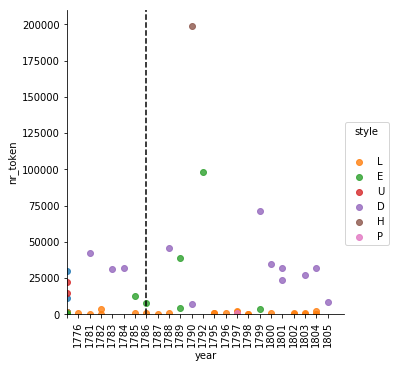

In [6]:
df = data.sort_values(["year"], ascending=True)[["name", "nr_token", "year", "style"]]

# Plot using Seaborn
sns.lmplot(x='year', y='nr_token', data=df,
          fit_reg=False,
          hue='style')

# Tweak using Matplotlib
plt.ylim(0, None)
plt.xlim(0, None)
plt.xticks(rotation=90)

plt.axvline(7, color="k", linestyle="--");





"""
x_pos = [x for x in range(1776, 1806)]
print(x_pos)
# swarm plot with schiller color palette
sns.swarmplot(x='year', y='nr_token', data=df,
             palette=schiller_type_colors)
plt.xticks(rotation=90)
# Thus we have to give more margin:
plt.subplots_adjust(bottom=0.4)

plt.axvline(8, color='r', linestyle='--', lw=2)
plt.plot()
"""

In [7]:
df

,name,nr_token,year,style
number,,,,
0093,Die Gesetzgebung des Lykurgus und Solon,11089.0,,
0028,die Entzückung an Laura,145.0,,L
0072,Das Mädchen von Orleans,153.0,,L
0030,die Ideale,497.0,,
0032,die Kindsmoerderin,757.0,,L
0033,die Teilung der Erde,245.0,,
0034,eine grossmutige Handlung,1027.0,,E
0035,eine Leichenphantasie,493.0,,
0036,Hektors Abschied,163.0,,L


Text(0.5,1,'')

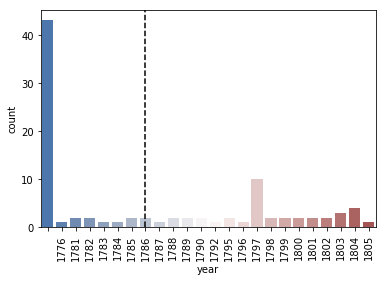

In [8]:
# Bar plot
# Count Plot (a.k.a. Bar Plot)
sns.countplot(x='year', data=df, palette="vlag") # rocket,deep. pastel (palette=)

# Rotate x-labels
plt.xticks(rotation=90)
plt.axvline(7, color="k", linestyle="--")
plt.title('')

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

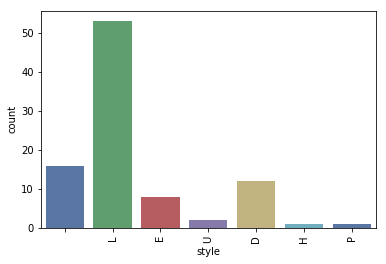

In [9]:
# Bar plot
# Count Plot (a.k.a. Bar Plot)
sns.countplot(x='style', data=df, palette="deep")

# Rotate x-labels
plt.xticks(rotation=90)

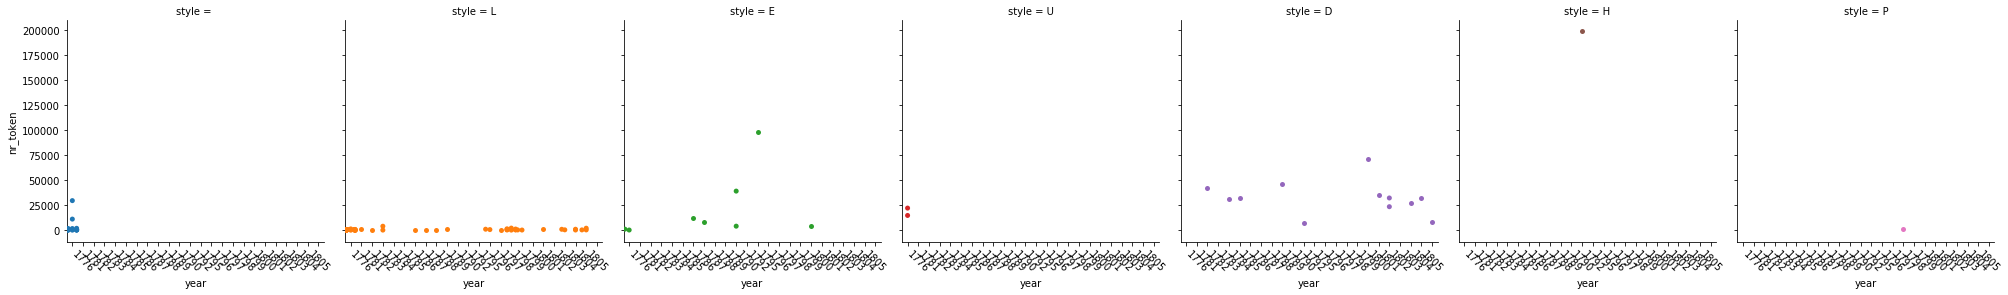

In [10]:
# Factor Plot
g = sns.factorplot(x='year',
                  y='nr_token',
                  data=df,
                  hue='style', # Color by stage
                  col='style', # Separate by stage
                  kind='swarm') # Swarmplot

# rotate x-axis labels
g.set_xticklabels(rotation=-45)

# Doesn't work because only rotates last plot
# plt.xticks(rotation=-45)

<h2>Verteilung der Textlänge über die Zeit</h2>

Aus dem vorhandenen DataFrame wird nun ein neuer erzeugt, der lediglich die beiden Felder 
year und nr_token besitzt.


In [11]:
text_length = data[["year", "nr_token"]]

Ab jetzt wird es visuell! Die %-Anweisung wird benötigt, damit Jupyter die Plots direkt im Notebook anzeigen kann.
Hier wird matplotlib zur Visualisierung benutzt, die numpy-Bibliothek für die numerische Datenverarbeitung 
wird später noch häufiger benötigt.

Mehr zur Inline-Darstellung in Jupyter: https://ipython.readthedocs.io/en/stable/interactive/plotting.html

Mehr zu matplotlib: https://matplotlib.org

Mehr zu numpy: http://www.numpy.org

Mehr zu set_index: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.set_index.html

Mehr zu agg: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.core.groupby.DataFrameGroupBy.agg.html

Mehr zu rename: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rename.html

In [12]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np


data['year'] = pd.to_datetime(data['year_dt'], errors='coerce')


#data[["year", "nr_token"]].set_index("year").resample('M').agg({'nr_token': 'mean'}).rename(columns={'nr_token': '#tokens'}).plot()
data[["year", "nr_token"]].set_index("year").resample('M').agg({'nr_token': 'mean'}).rename(columns={'nr_token': '#tokens'}).plot()

NameError: name 'pd' is not defined

In [13]:
data

,name,style,text,year,year_dt,nr_token,nr_adj,nr_noun,nr_verb,per_verb,per_noun,per_adj
number,,,,,,,,,,,,
0001,Demetrius,D,Demetrius an der russischen Grenze Er ist vo...,1805,1805-01-01,8486.0,600.0,1681.0,1482.0,17.464058,19.809097,7.070469
0002,Der versöhnte Menschenfeind,D,Der versöhnte Menschenfeind - Fragment Gegend...,1790,1790-01-01,7127.0,584.0,1328.0,1286.0,18.044058,18.633366,8.194191
0003,Die Braut von Messina,D,Die Braut von Messina oder die feindlichen Brü...,1803,1803-01-01,27129.0,2348.0,5122.0,3624.0,13.358399,18.880165,8.654945
0004,Die Huldigung der Künste,L,Ihrer Kaiserl. Hoheit der Frau Erbprinze...,1804,1804-01-01,1985.0,157.0,452.0,242.0,12.191436,22.770781,7.909320
0005,Die Jungfrau von Orleans,D,Die Jungfrau von Orleans Eine romantische Trag...,1801,1801-01-01,32189.0,2308.0,6195.0,4801.0,14.915033,19.245705,7.170151
0006,Die Räuber,D,Die Räuber Ein Schauspiel Quae medicame...,1781,1781-01-01,42202.0,3047.0,7807.0,7432.0,17.610540,18.499123,7.220037
0007,Die Verschwörung des Fiesco zu Genua,D,Die Verschwörung des Fiesco zu Genua Ein repub...,1783,1783-01-01,30978.0,2404.0,6242.0,5382.0,17.373620,20.149784,7.760346
0008,Don Carlos,D,"Don Carlos, Infant von Spanien Ein dramatisch...",1788,1788-01-01,45823.0,2795.0,7636.0,6911.0,15.081946,16.664121,6.099557
0009,Kabale und Liebe,D,Kabale und Liebe Ein bürgerliches Trauerspiel...,1784,1784-01-01,31778.0,2347.0,6126.0,5484.0,17.257222,19.277488,7.385613


<h2>Liste der längsten Artikel</h2>

Mehr zur Sortierung: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html

Mehr zur Spaltenauswahl: https://pandas.pydata.org/pandas-docs/stable/indexing.html

In [14]:
data.sort_values(["nr_token"], ascending=False)[["name", "nr_token", "year"]].head(10)

,name,nr_token,year
number,,,
0045,die Geschichte des 30jaehrigen Krieges,198543.0,1790
0055,Geschichten aus dem alten Pitaval,98003.0,1792
0012,Wallenstein,71183.0,1799
0008,Don Carlos,45823.0,1788
0006,Die Räuber,42202.0,1781
0021,der Geisterseher,39057.0,1789
0010,Maria Stuart,34801.0,1800
0005,Die Jungfrau von Orleans,32189.0,1801
0013,Wilhelm Tell,32164.0,1804


In [15]:
data.sort_values(["nr_token"], ascending=False)[["name", "nr_token", "year"]].tail(10)

,name,nr_token,year
number,,,
0062,Archimedes und der Schueler,108.0,
0085,Das Glück und die Weisheit,108.0,
0015,Amalia,106.0,1787
0027,die deutsche Muse,105.0,
0037,an Emma,97.0,1797
0065,Columbus,84.0,
0050,Zenith und Nadir,51.0,
0068,das Geschenk,46.0,
0059,an die Proselytenmacher,43.0,


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93 entries, 0001 to 0093
Data columns (total 12 columns):
name        93 non-null object
style       93 non-null object
text        93 non-null object
year        93 non-null object
year_dt     50 non-null datetime64[ns]
nr_token    93 non-null float64
nr_adj      93 non-null float64
nr_noun     93 non-null float64
nr_verb     93 non-null float64
per_verb    93 non-null float64
per_noun    93 non-null float64
per_adj     93 non-null float64
dtypes: datetime64[ns](1), float64(7), object(4)
memory usage: 9.4+ KB


<h2>using textstat for better information about the text difficulty</h2>

In [18]:
from textstat.textstat import textstat
# Python package to calculate statistics from text to determine readability,
# complexity and grade level of a particular corpus.
# https://github.com/shivam5992/textstat

def do_text_statistics(data):
    
    for i, row in data.iterrows():
        doc = row["name"] + " " + row["text"]
        
        textstat.syllable_count(doc) # count the number of syllables
        textstat.lexicon_count(doc, True) # count the number of words - True = without punctuations
        textstat.sentence_count(doc) # count the number of sentences
        
        
    
        data.set_value(i, "flesch_reading_ease", textstat.flesch_reading_ease(doc))
        data.set_value(i, "smog_index", textstat.smog_index(doc))
        data.set_value(i, "flesch_kincaid_grade", textstat.flesch_kincaid_grade(doc))
        data.set_value(i, "coleman_liau_index", textstat.coleman_liau_index(doc))
        data.set_value(i, "automated_readability_index", textstat.automated_readability_index(doc))
        data.set_value(i, "dale_chall_readability_score", textstat.dale_chall_readability_score(doc))
        data.set_value(i, "difficult_words", textstat.difficult_words(doc))
        data.set_value(i, "linsear_write_formula", textstat.linsear_write_formula(doc))
        data.set_value(i, "gunning_fog", textstat.gunning_fog(doc))
        data.set_value(i, "text_standard", textstat.text_standard(doc))
        
    return data


data = do_text_statistics(data)

/home/robinarthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/robinarthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/robinarthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/robinarthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/robinarthur/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use

In [1]:
data

NameError: name 'data' is not defined

Text(0.5,1,'test')

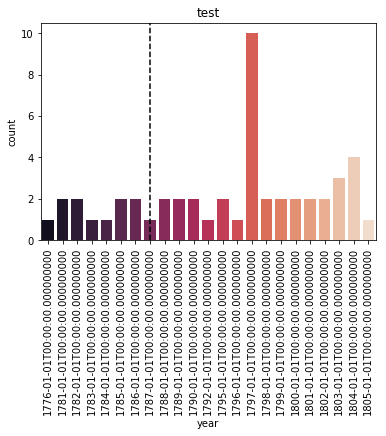

In [48]:
# Bar plot
# Count Plot (a.k.a. Bar Plot)
sns.countplot(x='year', data=data, palette="rocket")

# Rotate x-labels
plt.xticks(rotation=90)
plt.axvline(7, color="k", linestyle="--")
plt.title('test')